# Absolute PDE data analysis:

The  photon  detection  efficiency  (PDE)  is  one  of  the  most important  parameters  describing  the  sensitivity  of  a  SiPM  as a  function  of  wavelength  of  the  incident  light $\lambda$ and  the  applied overvoltage $\Delta$V:
$$
PDE= QE(\lambda) \times P_{G}(\lambda, \Delta V) \times \epsilon
$$
where $QE(\lambda)$ is the quantum efficiency, $P_{G}(\lambda, \Delta V)$ the Geiger probability, and $\epsilon$ the micro-cell fill factor (the percentage of it that is sensitive to light).  More details about each PDE component can be foundin the [Understanding and simulating SiPMs](https://www.sciencedirect.com/science/article/pii/S0168900218317704).  To study the PDE, our experimental setup at IdeaSquare at CERN was used:

![Schematic layouts of the developed experimental set-up for absolute PDE measurements](./images/PulsedSchematicV2.png)

In this notebook, the methods used for absolute (at a given $\lambda$) PDE vs. $\Delta$V measurement is reported.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from os import listdir
from os.path import isfile, join
from IPython.display import Image
import math

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import interp1d
from sipm_pde_absolute import PDE_Absolute

Welcome to JupyROOT 6.16/00


# PDE calculation, with step by step explonation:

To analyse the absolute PDE meauremts, **PDE_Absolute** class was developed and should be used. 
Its analyse the data at waveform level.
The absolute PDE is calculated using the so-called Poisson method from the average number of detected photons, corrected by factor $k_{LED}$ to take into account the un-correlated SiPM noise:

$$
k_{LED} = - \ln \left( P_{LED}(0) \right) + \ln \left( P_{dark}(0) \right)  = - \ln \left( \dfrac{N_{LED}(0)}{N_{LED}(total)}  \right) + \ln \left( \dfrac{N_{dark}(0)}{N_{dark}(total)}  \right)
$$

where $P_{LED}(0)$ and $P_{dark}(0)$ are the probabilities to detect 0 p.e. within time interval where photons from $LED$ are expected and within the $dark$ region where no exteral ligh are expected. $N_{dark}(0)$ and $N_{dark}(total)$ are the number of waveforms with no SiPM signal within the $dark$ regions preceding it and the total number of recorded waveforms, respectively.


The PDE can be calculated as:

$$
PDE(\Delta V, \lambda) = \frac{k_{LED}}{N_{ph}}
$$

where $N_{ph}$ is the average number of photons hitting the SiPM. The $N_{ph}$ can  be  estimated  from  converting  the  photocurrent from the calibrated photodiode as:

$$
N_{ph} = \frac{ I_{PD} \times R }{f \times QE_{PD}(\lambda) \times e^{-} } \times \frac{A_{SiPM}}{A_{PD}}
$$

where $I_{PD}$ is the calibrated photodiode current (corrcted to dark current), $R$ light power ratio, $QE_{PD}(\lambda)$ is the calibrated photodiode quantum efficency at a given wavelength $\lambda$, $f$ is the pulse repetition frequency (typicaly 500 - 1000 Hz), $e^{-}$ is the elementary charge, $A_{SiPM}$ and $A_{PD}$ are the SiPM and calibrated Photodiodes active areas respectively. 

First, lets create the object of such class:

In [2]:
pde_405nm_no_baseline = PDE_Absolute()

class fro SiPM PDE characterization has been created
trigger_range == NaN
nsb_range == NaN


We see that no **trigger_range** and **nsb_range** were not defined:
* **trigger_range** - time window (at a waveform) at which the light from LED is expected
* **nsb_range** - time window (at a waveform) at which the SiPM was in dark and can be used for dark analysis

At each wavelength $\lambda$ we are measuring the PDE as a function of Overvoltage $\Delta$V. Therefore, we should have a folder with measurements, where we have a measuremts at different bias Voltages $V_{bias}$ or  $\Delta$V = $V_{bias}$ - $V_{BD}$. As an exaple, we have *'/mnt_data/data/FbK_Terzina/NUV_3x3_40um/405nm_6.2ns_1k_n8/'*. Which containes:

In [3]:
data_path = './data_example/FbK_NUVHD_3x3_40um_nc/405nm_1k_6.2ns_n8/'
!ls $data_path

-30.000_V_T_25.000_C.txt.root  -36.400_V_T_25.000_C.txt.root
-35.200_V_T_25.000_C.txt.root  -37.600_V_T_25.000_C.txt.root


**Important :** during PDE measuremts, we need to generate light within very short time window. Therfore, we need to generate very short electrival pulses to trigger LEDs, for example pulses of 3-5 ns width with amplitude of a few volts (2-4 V). Such pulses creates high electronics noise. Therefore, it is useful for furthe analysis to characterize such noise and subtract if from useful data further. For this, we recomend to acquire one data file at $V_{bias}$ < $V_{BD}$. In this example, this file is **-30.000_V_T_25.000_C.txt.root**. Now, let set the path to folder with data and set also the baseline vltage:

In [4]:
pde_405nm_no_baseline.get_root_file(data_path, baseline = '-30.000')

lsts see all found data (without baseline data)

In [5]:
pde_405nm_no_baseline.root_files

['-35.200_V_T_25.000_C.txt.root',
 '-36.400_V_T_25.000_C.txt.root',
 '-37.600_V_T_25.000_C.txt.root']

and file with baseline:

In [6]:
pde_405nm_no_baseline.baseline_root_file

'-30.000_V_T_25.000_C.txt.root'

lets calculate the time window where the light from LED is expected. For this we at each waveform we should find the maximum apmlitude and its position, and build the distribution of time position of maximum: 

   start: get_trigger_range
       - file :  -35.200_V_T_25.000_C.txt.root



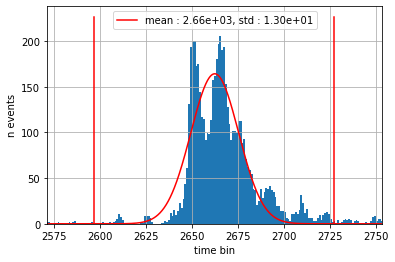

       - found trigger range :  (2597, 2727)
       - nsb_range =  (0, 1298)
   end: get_trigger_range



In [7]:
pde_405nm_no_baseline.get_trigger_range('-35.200_V_T_25.000_C.txt.root', doshow = True)

we can notice, the strange behavoir. Normaly, the time possition should have Gaussian shape. To understand it better lets, analyse one file:

In [8]:
pde_405nm_no_baseline.ana_row_data('-35.200_V_T_25.000_C.txt.root')

   start: ana_row_data
       - file :  -35.200_V_T_25.000_C.txt.root

   end: ana_row_data



As a result from anaylysis we have dictionary **data**, where the **key** is the bias voltage. This dictionary containes a dictionary with data parameters like: 

In [9]:
pde_405nm_no_baseline.data['35.2'].keys()

dict_keys(['photdiode current', 'photdiode current std', 'n light', 'n dcr', 'index max', 'n points', 'increment', 'amplitude', 'charge'])

where:
* **photdiode current** -> photodiode current;
* **n light** is $N_{LED}$ (see formula for PDE calculation)
* **n dcr** is $N_{dark}$  (see formula for PDE calculation)
* **index max** -> the index of the waveform point with the highest amplitude
* **n points** -> numer of points at waveform
* **increment** -> waveform increment at s
* **amplitude** -> waveform amplitude values at V
* **charge** -> signal charge

Lets plot the distibution of the argument of local maximum for each waveform:

Text(0, 0.5, 'Events')

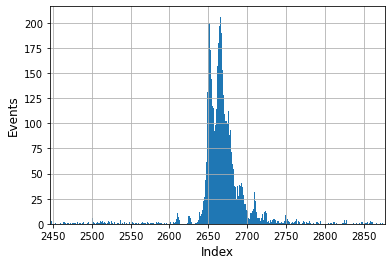

In [10]:
local_max_index = pde_405nm_no_baseline.data['35.2']['index max']
plt.hist(local_max_index, bins = pde_405nm_no_baseline.data['35.2']['n points'])
plt.xlim(pde_405nm_no_baseline.trigger_range[0] - 150, 
         pde_405nm_no_baseline.trigger_range[1] + 150)
plt.grid()
plt.xlabel("Index", fontsize=12)
plt.ylabel("Events", fontsize=12)

and the distrubution of $n_{light}$ and $n_{dcr}$:

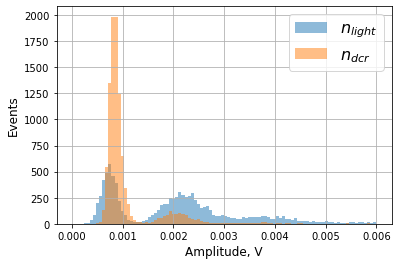

In [11]:
n_light_no_baseline = pde_405nm_no_baseline.data['35.2']['n light']
n_dcr_no_baseline = pde_405nm_no_baseline.data['35.2']['n dcr']

plt.hist(n_light_no_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='$n_{light}$')
plt.hist(n_dcr_no_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='$n_{dcr}$')
plt.grid()
plt.xlabel("Amplitude, V", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(fontsize=16)

we can observe thet 0 p.e. peak is much wider for $n_{light}$ with respect to $n_{dcr}$. This is due to electronics noise created by pulse generator used to bias LED. We can also see it on waveforms:

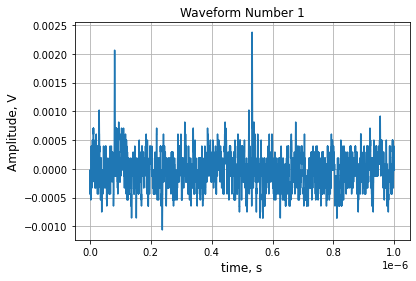

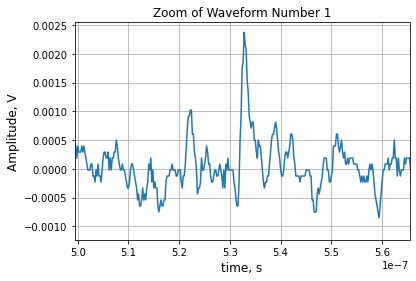

In [12]:
waveform_number = 1
x_time = np.arange(0, pde_405nm_no_baseline.data['35.2']['n points']*pde_405nm_no_baseline.data['35.2']['increment'], 
                   pde_405nm_no_baseline.data['35.2']['increment'])
y_ampliude = pde_405nm_no_baseline.data['35.2']['amplitude'][waveform_number]

plt.plot(x_time, y_ampliude)
plt.grid()
plt.title('Waveform Number {:}'.format(waveform_number))
plt.xlabel("time, s", fontsize=12)
plt.ylabel("Amplitude, V", fontsize=12)
plt.show()

plt.plot(x_time, y_ampliude)
plt.grid()
plt.title('Zoom of Waveform Number {:}'.format(waveform_number))
plt.xlabel("time, s", fontsize=12)
plt.ylabel("Amplitude, V", fontsize=12)
plt.xlim(pde_405nm_no_baseline.trigger_range[0]*pde_405nm_no_baseline.data['35.2']['increment'] - 20e-9, 
         pde_405nm_no_baseline.trigger_range[1]*pde_405nm_no_baseline.data['35.2']['increment'] + 20e-9)
plt.show()

We can observe, the high electronics noise around time window where we she photons from LED. To remove this nise, we can use the baseline data acquired at $V_{bias}$ < $V_{BD}$

### PDE with baseline calculation: 

Now, lets create another object of **PDE_Absolute()** class, but this time we will use the baseline. We can calculate a baseline -> which is simply the average waveform:

In [13]:
data_path = './data_example/FbK_NUVHD_3x3_40um_nc/405nm_1k_6.2ns_n8/'
!ls $data_path

-30.000_V_T_25.000_C.txt.root  -36.400_V_T_25.000_C.txt.root
-35.200_V_T_25.000_C.txt.root  -37.600_V_T_25.000_C.txt.root


In [14]:
pde_405nm = PDE_Absolute()
pde_405nm.get_root_file(data_path, baseline = '-30.000')
pde_405nm.get_baseline()

class fro SiPM PDE characterization has been created
trigger_range == NaN
nsb_range == NaN


Lets see our baseline, which containes only the electronics noise:

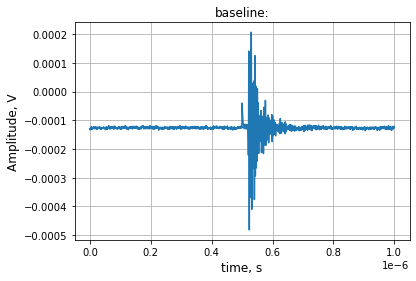

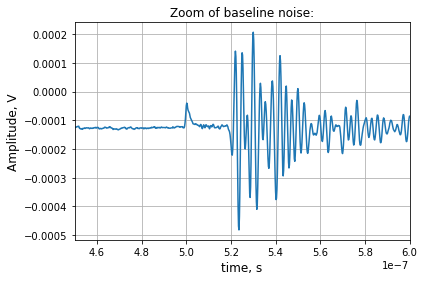

In [15]:
x_time = np.arange(0, pde_405nm.baseline_increment*pde_405nm.baseline_n_points, pde_405nm.baseline_increment)

plt.plot(x_time, pde_405nm.baseline_amplitude)
plt.grid()
plt.title('baseline:')
plt.xlabel("time, s", fontsize=12)
plt.ylabel("Amplitude, V", fontsize=12)
plt.show()

x_time = np.arange(0, pde_405nm.baseline_increment*pde_405nm.baseline_n_points, pde_405nm.baseline_increment)

plt.plot(x_time, pde_405nm.baseline_amplitude)
plt.grid()
plt.title('Zoom of baseline noise:')
plt.xlabel("time, s", fontsize=12)
plt.ylabel("Amplitude, V", fontsize=12)
plt.xlim(0.45e-6, 0.6e-6)
plt.show()

Lets now calculate the time window where the light from LED is expected but now the baseline calculated previously will be used: 

   start: get_trigger_range
       - file :  -36.400_V_T_25.000_C.txt.root



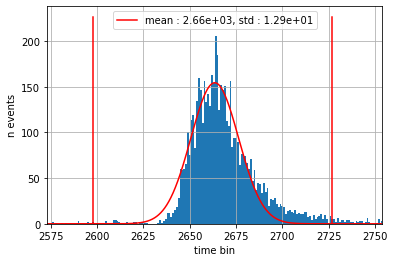

       - found trigger range :  (2598, 2727)
       - nsb_range =  (0, 1299)
   end: get_trigger_range



In [16]:
pde_405nm.get_trigger_range('-36.400_V_T_25.000_C.txt.root', doshow = True)

In [17]:
pde_405nm.trigger_range

(2598, 2727)

Lets, analyse one file:

In [18]:
pde_405nm.ana_row_data('-35.200_V_T_25.000_C.txt.root')

   start: ana_row_data
       - file :  -35.200_V_T_25.000_C.txt.root

   end: ana_row_data



Lets plot the distibution of the argument of local maximum before and after baseline correction:

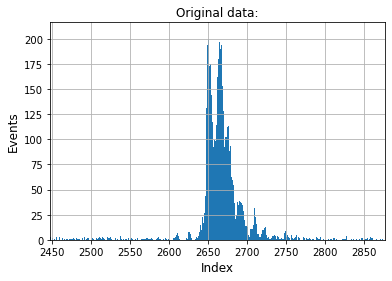

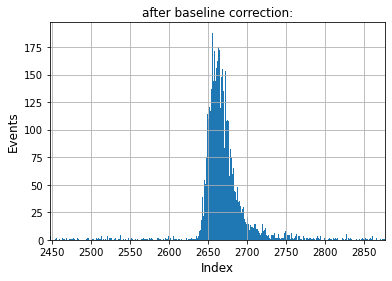

In [19]:
local_max_index_with_bl = pde_405nm.data['35.2']['index max']

plt.hist(local_max_index, bins = pde_405nm.data['35.2']['n points'])

plt.xlim(pde_405nm.trigger_range[0] - 150, 
         pde_405nm.trigger_range[1] + 150)
plt.grid()
plt.title('Original data:')
plt.xlabel("Index", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.show()

plt.hist(local_max_index_with_bl, bins = pde_405nm.data['35.2']['n points'])
plt.title('after baseline correction:')
plt.xlim(pde_405nm.trigger_range[0] - 150, 
         pde_405nm.trigger_range[1] + 150)
plt.grid()
plt.xlabel("Index", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.show()

we can see significan improvements after baseline correction.
Now the same thing for $n_{light}$ and $n_{dark}$:

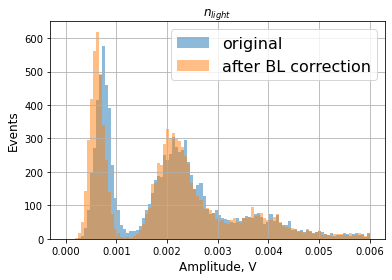

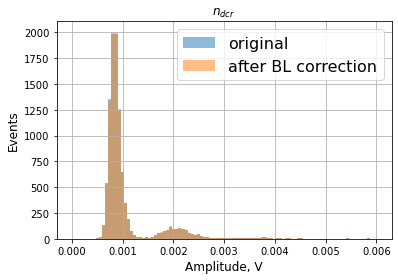

In [20]:
n_light_with_baseline = pde_405nm.data['35.2']['n light']
n_dcr_with_baseline = pde_405nm.data['35.2']['n dcr']

plt.hist(n_light_no_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='original')
plt.hist(n_light_with_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='after BL correction')
plt.grid()
plt.xlabel("Amplitude, V", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.title('$n_{light}$')
plt.legend(fontsize=16)
plt.show()

plt.hist(n_dcr_no_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='original')
plt.hist(n_dcr_with_baseline, bins = 100, range = [0, 0.006], alpha = 0.5, label='after BL correction')
plt.grid()
plt.title('$n_{dcr}$')
plt.xlabel("Amplitude, V", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend(fontsize=16)
plt.show()

No any imrovement for $n_{dark}$ as expected, since the time window for $n_{dark}$ calculation is outside the noise created from pulse generator

Now we can calcualte $P_{LED}(0) = \frac{N_{LED}(0)}{N_{LED}(Total)}$ by analysing the destribution and countig the number of events with amplitude smaller then 0.5 p.e:

   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - distance_peaks:  8.75
       - found :  7
       - pe_calc :  0.001456
       - found :  7
       - p.e. :  0.001456
       - left_element :  0.0  right_element :  0.001176
       - fit results :  [5.49473173e+02 5.90211078e-04 1.38756930e-04]
       - left_element :  0.001176  right_element :  0.002632
       - fit results :  [2.99178465e+02 2.10599762e-03 3.24352106e-04]
       - fit parameters : 
            - amplitude_0 :  549.644309488075
            - gain        :  0.0015323704953974454
            - sigma_0     :  0.00013862363698110923
            - amplitude_1 :  291.9017033749493
            - sigma_1     :  0.00034899748262101746
            - shift       :  -0.0009422390879396843
       - threshold : 

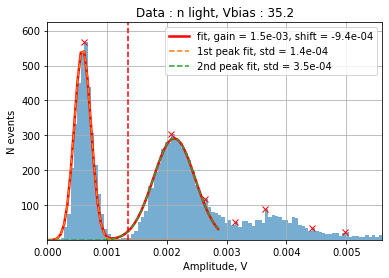

   end: ana_distribution



0.3553981937602627

In [21]:
ap0 = 1000        # first peak amplitude
gain_start = 0.0007 # gain, distance between peaks
sigma0 = 1.e-4    # STD of the first peak
ap1 = 100         # second peak amplitude
sigma1 = 1.e-5    # STD of the second peak
shift = 0.        # shift of the first peak

fit_parameters = {'amplitude_0' : ap0, 
                 'gain' : gain_start,
                 'sigma_0' : sigma0,
                 'amplitude_1' : ap1,
                 'sigma_1': sigma1,
                 'shift': shift}

# Fit parameters range:

ap0_range = (0, 10000)             # first peak amplitude range
gain_range = (1e-4, 0.002)          # gain range
sigma_0_range = (1e-5, 1.e-3)        # range of STD of the first peak
ap1_range = (0, 10000)             # second peak amplitude range
sigsigma_1_rangema1 = (1e-5, 1.5e-3)  # range of STD of the second peak
shift_range = (-0.01, 0.01)        # shift range, of the first peak

fit_parameters_range = {'amplitude_0' : ap0_range, 
                 'gain' : gain_range,
                 'sigma_0' : sigma_0_range,
                 'amplitude_1' : ap1_range,
                 'sigma_1': sigsigma_1_rangema1,
                 'shift': shift_range}

n0_light, n_total_light, pe_calc, threshold = pde_405nm.ana_distribution('35.2', 'n light', fit_parameters, fit_parameters_range, np.nan, doshow = True)
p0_light = n0_light/n_total_light
p0_light

Similar for $P_{dark}(0) = \frac{N_{dark}(0)}{N_{dark}(Total)}$:

No handles with labels found to put in legend.


   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n dcr
       - Threshold     :  0.0015157865429111107

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - threshold :  0.0015157865429111107
       - threshold element N :  28
       - n_0   8626.0, with err 92.88 
       - n_all 9988.0, with err 99.94 
       - P0    0.86, with err 0.01 
       - DCR Poisson 564293.5881134542


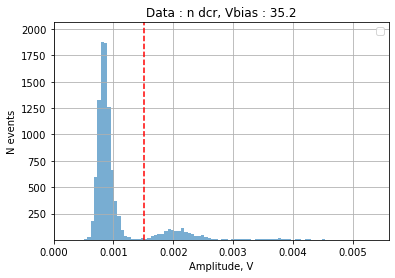

   end: ana_distribution



0.8636363636363636

In [22]:
n0_dark, n_total_dark, pe_calc_dark, threshold_dark = pde_405nm.ana_distribution('35.2', 'n dcr', fit_parameters, fit_parameters_range, pe_calc, threshold, doshow = True)
p0_dark = n0_dark/n_total_dark
p0_dark

Since, time window for $P_{LED}(0)$ and $P_{dark}(0)$ are different, we should correct the $P_{dark}(0)$ to this difference:

In [23]:
time_light = pde_405nm.trigger_range[1] - pde_405nm.trigger_range[0]
time_dark = pde_405nm.nsb_range[1] - pde_405nm.nsb_range[0]
p0_dark_corrected = 1 - time_light*(1 - p0_dark)/time_dark

Now we can calculate the average number of detected photons from LED as:

In [24]:
k_LED = -math.log(p0_light) + math.log(p0_dark_corrected)
print('average number of detected photons is : {:.3f}'.format(k_LED))

average number of detected photons is : 1.021


now lets calculate the errors for $k_{LED}$, which is:

$$
\Delta k_{LED} = \sqrt{ \left( \Delta k_{LED}(light) \right)^{2} + \left( \Delta k_{LED}(dark) \right)^{2} }
$$

Since we have Binominal distribution, the STD of mean can be calculated as:

$$
\Delta N(0) = \sqrt{ \left ( N(total) \cdot P(0) (1 - P(0) ) \right)}
$$

Thefore, the $P(0)$ error can be calculated as:

$$
\Delta P(0) = \frac{\Delta N(0)}{N(total)}
$$

So the uncertainty of $k$ can be calculated as: 

$$
\Delta k = k' = \frac{\partial -Ln(P(0))}{\partial P(0)} \cdot \Delta P(0) = \frac{\Delta P(0)}{P(0)} = \frac{N(total)}{N(0)} \times \Delta P(0) = \frac{N(total)}{N(0)} \times \frac{\Delta N(0)}{N(total)} = \frac{\sqrt{ \left ( N(total) \cdot P(0) (1 - P(0) ) \right)}}{N(0)}
$$

In [25]:
k_LED_light_err = math.sqrt( n0_light*(1. - n0_light/n_total_light) )/n0_light
k_LED_dark_err = math.sqrt( n0_dark*(1. - n0_dark/n_total_dark) )/n0_dark
k_LED_err = math.sqrt( k_LED_light_err*k_LED_light_err +  k_LED_dark_err*k_LED_dark_err)
print('The error of average number of detected photons is : {:.3f}'.format(k_LED_err))

The error of average number of detected photons is : 0.014


So we calculated the average number of photons detected by SiPM. Now we can calcualte the PDE as:
$$
    PDE(\Delta V, \lambda) = \frac{k_{LED}}{N_{ph}}
$$

Now we need to calculate $N_{ph}$ as:

$$
N_{ph} = \frac{ I_{PD} \times R }{f \times QE_{PD}(\lambda) \times e^{-} } \times \frac{A_{SiPM}}{A_{PD}}
$$

𝑅 - is the power ratio, $𝑅=𝑃_{𝑃𝐷}/𝑃_{𝑆𝑖𝑃𝑀}$, between the light intensity measured by the calibrated photodiode, $𝑃_{𝑃𝐷}$, and the SiPM, $𝑃_{𝑆𝑖𝑃𝑀}$, is measured experimentally, by replasing the SiPM with another calibrated photodiode

In [26]:
file_with_2pd = '/home/andrii/work/ana_waveforms/sipm_pde_absolute/FbK_ratio_405nm.txt'
!head $file_with_2pd

In [27]:
pde_405nm.calculate_ratio_file('/home/andrii/work/ana_waveforms/sipm_pde_absolute/FbK_ratio_405nm.txt')
pde_405nm.power_r

2.7293634e-05

The $𝑄𝐸_{𝑃𝐷}$ is provided by producer and located at:

In [28]:
qe_data = 'PD_S1337-1010BQ_SN01.out'

Lets read and plot QE for our device:

Text(0, 0.5, 'Photodiode QE, %')

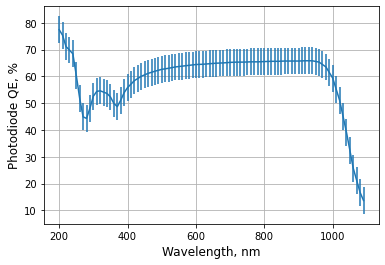

In [29]:
pde_405nm.get_qe('PD_S1337-1010BQ_SN01.out')

wl_qe = np.arange(200, 1100, 10)
qe = pde_405nm.f_qe(wl_qe)

plt.errorbar(wl_qe, qe, yerr = 5)
plt.grid()
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Photodiode QE, %", fontsize=12)

our measurements were done at $f$ = 1KHz, SiPM area is 3x3 $mm^2$ while the Photodiode area is 10x10 $mm^2$ so now we can calculate the $N_{ph}$ as:

In [30]:
pd_current = np.abs(pde_405nm.data['35.2']['photdiode current'])
f = 1000
wavelength = 405 
R = np.abs(pde_405nm.power_r)
qe = pde_405nm.f_qe(wavelength)/100
qe_err = 0.05*qe
el = scipy.constants.e
sipm_area = 0.09 # cm2
pd_area = 1 # cm2

n_ph = pd_current*R*sipm_area/(qe*f*el*pd_area)

print('average number of photons reaching the SiPM active area is : {:.3f}'.format(n_ph))

average number of photons reaching the SiPM active area is : 1.717


now, we should calculate the error for average number of detected photons. This error is determined by two independent errors:
* $\Delta n_{ph}(QE)$ photodiode calibration presision (for our photodiode is 5%)
* $\Delta n_{ph}(I)$ light stability i.e. photodiode current measuremtns error

Since, those two errors are independent, the totla error $n_{ph}^{err}$ can be calculated as:

$$
 \Delta n_{ph} = \sqrt{ \Delta n_{ph}(QE)^2 + \Delta n_{ph}(I)^2}
$$

In [31]:
pd_current_err = pde_405nm.data['35.2']['photdiode current std']
pd_current = pde_405nm.data['35.2']['photdiode current']

n_ph_err_qe = 0.05*qe*pd_current*R*sipm_area/(qe*qe*f*el*pd_area)
n_ph_err_current = pd_current_err*R*sipm_area/(qe*f*el*pd_area)
n_ph_err = math.sqrt(n_ph_err_qe*n_ph_err_qe + n_ph_err_current*n_ph_err_current)

print('Error of the number of photons reaching the SiPM active area is : {:.3f}'.format(n_ph_err))

Error of the number of photons reaching the SiPM active area is : 0.086


Same results can be obtaned from **get_n_pe** function as:

In [32]:
r_area = sipm_area/pd_area
n_pe, n_pe_err  = pde_405nm.get_n_pe(f, r_area, pd_current, pd_current_err, R, qe, qe_err)

print('Average number of photons reaching the SiPM active area is : {:.3f}, with error of {:.3f}'.format(n_pe, n_pe_err))

Average number of photons reaching the SiPM active area is : 1.717, with error of 0.086


Now we are ready to calculate **PDE** as:
$$
PDE = 100 \% \times \frac{k_{LED}}{n_{ph}}
$$

In [33]:
pde = 100*k_LED/n_ph
print('PDE is : {:.3f} %'.format(pde))

PDE is : 59.441 %


and **PDE** error as sum of $k_{LED}$ and $n_{ph}$ errors:
$$ 
\Delta PDE = 100 \% \times \sqrt { \left(  \frac{\Delta k_{LED}}{n_{ph}}  \right)^{2} + \left( \frac{ k_{LED} \cdot \Delta n_{ph} }{n_{ph}^{2}} \right)^{2} }
$$

In [34]:
pde_err = 100* math.sqrt( (k_LED_err/n_ph)*(k_LED_err/n_ph) + ((n_ph_err*k_LED)/(n_ph*n_ph))*((n_ph_err*k_LED)/(n_ph*n_ph)) )
print('PDE error is : {:.3f} %'.format(pde_err))

PDE error is : 3.086 %


We can do similar calcualtion by using **calc_pde** function, as:

   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - distance_peaks:  8.75
       - found :  7
       - pe_calc :  0.001456
       - found :  7
       - p.e. :  0.001456
       - left_element :  0.0  right_element :  0.001176
       - fit results :  [5.49473173e+02 5.90211078e-04 1.38756930e-04]
       - left_element :  0.001176  right_element :  0.002632
       - fit results :  [2.99178465e+02 2.10599762e-03 3.24352106e-04]
       - fit parameters : 
            - amplitude_0 :  549.644309488075
            - gain        :  0.0015323704953974454
            - sigma_0     :  0.00013862363698110923
            - amplitude_1 :  291.9017033749493
            - sigma_1     :  0.00034899748262101746
            - shift       :  -0.0009422390879396843
       - threshold : 

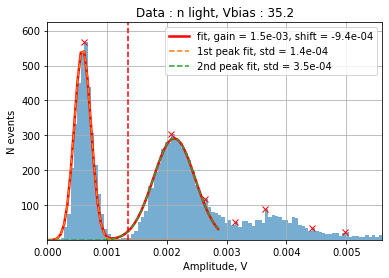

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n dcr
       - Threshold     :  0.001356316655156484

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - threshold :  0.001356316655156484
       - threshold element N :  25
       - n_0   8584.0, with err 92.65 
       - n_all 9988.0, with err 99.94 
       - P0    0.86, with err 0.01 
       - DCR Poisson 583080.70473106


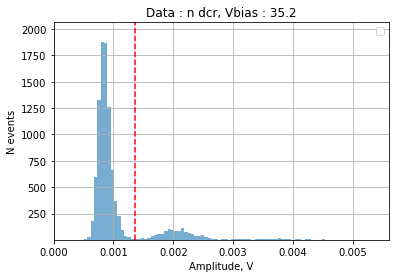

   end: ana_distribution

k LED 1.02, err 0.01 
n pe  1.72, err 0.09 
PDE  59.42, err 3.08 


In [36]:
v_bias_key = '35.2'
pe_aproximate = 0.001
r_area = sipm_area/pd_area
qe_data = 'PD_S1337-1010BQ_SN01.out'
file_with_2pd = '/home/andrii/work/ana_waveforms/sipm_pde_absolute/FbK_ratio_405nm.txt'
wavelength = 405

ap0 = 1000        # first peak amplitude
gain_start = 0.0007 # gain, distance between peaks
sigma0 = 1.e-4    # STD of the first peak
ap1 = 100         # second peak amplitude
sigma1 = 1.e-5    # STD of the second peak
shift = 0.        # shift of the first peak

fit_parameters = {'amplitude_0' : ap0, 
                 'gain' : gain_start,
                 'sigma_0' : sigma0,
                 'amplitude_1' : ap1,
                 'sigma_1': sigma1,
                 'shift': shift}

# Fit parameters range:

ap0_range = (0, 10000)             # first peak amplitude range
gain_range = (1e-4, 0.002)          # gain range
sigma_0_range = (1e-5, 1.e-3)        # range of STD of the first peak
ap1_range = (0, 10000)             # second peak amplitude range
sigsigma_1_rangema1 = (1e-5, 1.5e-3)  # range of STD of the second peak
shift_range = (-0.01, 0.01)        # shift range, of the first peak

fit_parameters_range = {'amplitude_0' : ap0_range, 
                 'gain' : gain_range,
                 'sigma_0' : sigma_0_range,
                 'amplitude_1' : ap1_range,
                 'sigma_1': sigsigma_1_rangema1,
                 'shift': shift_range}


pde_405nm.calc_pde('35.2', fit_parameters, fit_parameters_range, r_area, qe_data, file_with_2pd, wavelength, frequency = 1000, qe_err = 5, doshow = True)

# PDE calculation, fast:

### Define Constants:

In [50]:
data_path = '/mnt_data/data/FbK_Terzina/NUV_3x3_40um/405nm_6.2ns_1k_n8/'

qe_data = 'PD_S1337-1010BQ_SN01.out'
file_with_2pd = '/home/andrii/work/ana_waveforms/sipm_pde_absolute/FbK_ratio_405nm.txt'

sipm_area =0.09
pd_area = 1.
frequncy = 1000.
wavelength = 405.

### Create object of PDE_Absolute Class:

In [51]:
pde_405nm_fast = PDE_Absolute()
pde_405nm_fast.get_root_file(data_path, baseline = '-30.000')
pde_405nm_fast.get_baseline()

class fro SiPM PDE characterization has been created
trigger_range == NaN
nsb_range == NaN


### Claculate LED time window:

   start: get_trigger_range
       - file :  -36.400_V_T_25.000_C.txt.root



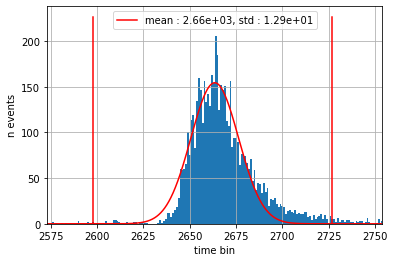

       - found trigger range :  (2598, 2727)
       - nsb_range =  (0, 1299)
   end: get_trigger_range



In [52]:
pde_405nm_fast.get_trigger_range('-36.400_V_T_25.000_C.txt.root', doshow = True)

### Set NBS time window == to LED time window: 

In [53]:
pde_405nm_fast.nsb_range = (0, pde_405nm_fast.trigger_range[1] - pde_405nm_fast.trigger_range[0])
pde_405nm_fast.nsb_range

(0, 129)

### Analyse row data: 

In [54]:
for i_file in pde_405nm_fast.root_files[:15]:
    print('file : ', i_file)
    pde_405nm_fast.ana_row_data(i_file)
    

#    pde_405nm_fast.calc_pde('35.2', 0.001, 0.09, qe_data, file_with_2pd, 405, frequency = 1000, doshow = True)

file :  -35.200_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -35.200_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -35.600_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -35.600_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -36.000_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -36.000_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -36.400_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -36.400_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -36.800_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -36.800_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -37.200_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -37.200_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -37.600_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -37.600_V_T_25.000_C.txt.root

   end: ana_row_data

file :  -38.000_V_T_25.000_C.txt.root
   start: ana_row_data
       - file :  -38.0

### Calculate PDE:

key :  35.2
   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - distance_peaks:  8.75
       - found :  7
       - pe_calc :  0.001456
       - found :  7
       - p.e. :  0.001456
       - left_element :  0.0  right_element :  0.001176
       - fit results :  [5.49473173e+02 5.90211078e-04 1.38756930e-04]
       - left_element :  0.001176  right_element :  0.002632
       - fit results :  [2.99178465e+02 2.10599762e-03 3.24352106e-04]
       - fit parameters : 
            - amplitude_0 :  549.6443913167811
            - gain        :  0.0015323705978061348
            - sigma_0     :  0.00013862359384301447
            - amplitude_1 :  291.9014190370537
            - sigma_1     :  0.00034899816963726837
            - shift       :  -0.0009422392252712785
       -

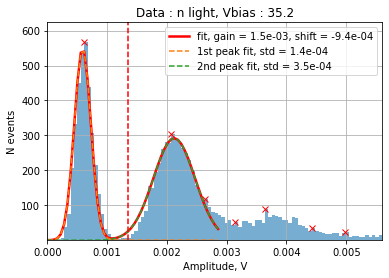

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  35.2
       - data name     :  n dcr
       - Threshold     :  0.001356316671437924

       - p.e. aproxim. :  0.0007
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0007
       - threshold :  0.001356316671437924
       - threshold element N :  25
       - n_0   9848.0, with err 99.24 
       - n_all 9999.0, with err 99.99 
       - P0    0.98, with err 0.01 
       - DCR Poisson 589794.5392077507


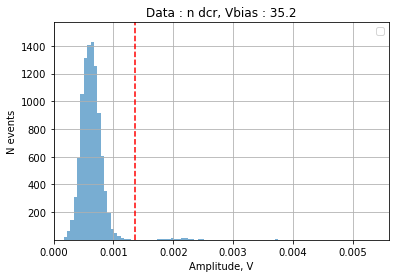

   end: ana_distribution

k LED 1.02, err 0.01 
n pe  1.72, err 0.09 
PDE  59.35, err 3.07 
key :  35.6
   start: ana_distribution
       - Vbias         :  35.6
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0015323705978061348
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0015323705978061348
       - distance_peaks:  8.75
       - found :  6
       - pe_calc :  0.0017162550695428711
       - found :  6
       - p.e. :  0.0017162550695428711
       - left_element :  0.0  right_element :  0.0012258964782449078
       - fit results :  [1.01100000e+03 6.12948239e-04 1.00000000e-05]
       - left_element :  0.0012258964782449078  right_element :  0.002942151547787779
       - fit results :  [5.76000000e+02 1.09122307e+01 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1086.8732091674972
            - gain        :  0.0017891146110987353
            - sigma_0   

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


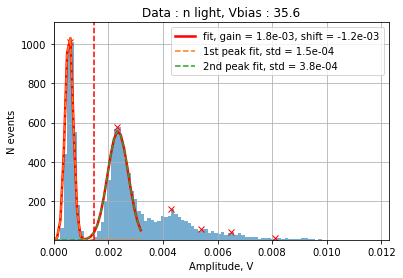

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  35.6
       - data name     :  n dcr
       - Threshold     :  0.0014596897559659761

       - p.e. aproxim. :  0.0015323705978061348
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0015323705978061348
       - threshold :  0.0014596897559659761
       - threshold element N :  12
       - n_0   9814.0, with err 99.07 
       - n_all 10000.0, with err 100.00 
       - P0    0.98, with err 0.01 
       - DCR Poisson 727719.1986951155


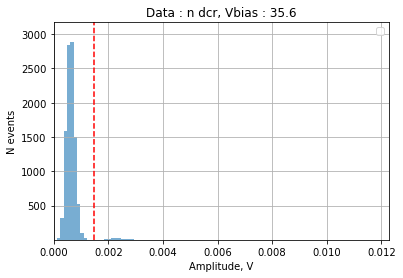

   end: ana_distribution

k LED 1.09, err 0.01 
n pe  1.72, err 0.09 
PDE  63.75, err 3.30 
key :  36.0
   start: ana_distribution
       - Vbias         :  36.0
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0017891146110987353
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0017891146110987353
       - distance_peaks:  8.75
       - found :  5
       - pe_calc :  0.0020038083644305835
       - found :  5
       - p.e. :  0.0020038083644305835
       - left_element :  0.0  right_element :  0.0012881625199910893
       - fit results :  [1.21000000e+03 5.72516676e-04 1.00000000e-05]
       - left_element :  0.0012881625199910893  right_element :  0.0032919708844216726
       - fit results :  [5.98000000e+02 1.14503335e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1314.531341569722
            - gain        :  0.0020929215622612378
            - sigma_0   

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


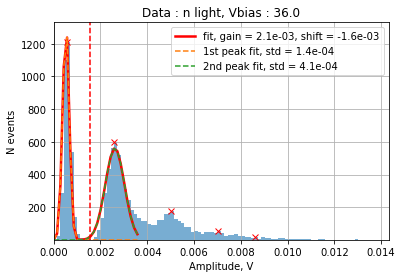

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  36.0
       - data name     :  n dcr
       - Threshold     :  0.00156952101204946

       - p.e. aproxim. :  0.0017891146110987353
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0017891146110987353
       - threshold :  0.00156952101204946
       - threshold element N :  11
       - n_0   9774.0, with err 98.86 
       - n_all 10000.0, with err 100.00 
       - P0    0.98, with err 0.01 
       - DCR Poisson 886019.1529489363


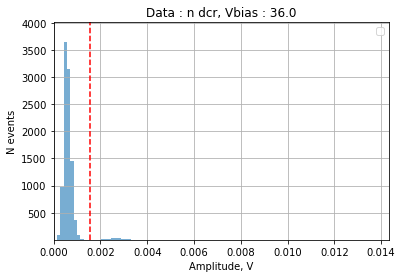

   end: ana_distribution

k LED 1.07, err 0.01 
n pe  1.72, err 0.09 
PDE  62.43, err 3.23 
key :  36.4
   start: ana_distribution
       - Vbias         :  36.4
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0020929215622612378
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0020929215622612378
       - distance_peaks:  8.75
       - found :  6
       - pe_calc :  0.0023440721497325866
       - found :  6
       - p.e. :  0.0023440721497325866
       - left_element :  0.0  right_element :  0.0013394697998471922
       - fit results :  [1.52300000e+03 5.02301175e-04 1.00000000e-05]
       - left_element :  0.0013394697998471922  right_element :  0.0036835419495797788
       - fit results :  [6.30000000e+02 1.00460235e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1515.9540039529634
            - gain        :  0.0023958214802977727
            - sigma_0  

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


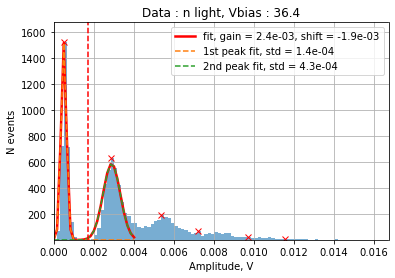

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  36.4
       - data name     :  n dcr
       - Threshold     :  0.0017008834167470859

       - p.e. aproxim. :  0.0020929215622612378
       - Bin size      :  9.999999999999999e-06
       - N bins        :  100
       - pe_aproximate :  0.0020929215622612378
       - threshold :  0.0017008834167470859
       - threshold element N :  11
       - n_0   9770.0, with err 98.84 
       - n_all 9999.0, with err 99.99 
       - P0    0.98, with err 0.01 
       - DCR Poisson 898008.6022876339


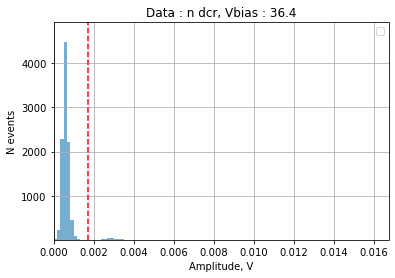

   end: ana_distribution

k LED 1.11, err 0.01 
n pe  1.72, err 0.09 
PDE  64.99, err 3.36 
key :  36.8
   start: ana_distribution
       - Vbias         :  36.8
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0023958214802977727
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.0023958214802977727
       - distance_peaks:  8.75
       - found :  7
       - pe_calc :  0.0024916543395096837
       - found :  7
       - p.e. :  0.0024916543395096837
       - left_element :  0.0  right_element :  0.0015333257473905744
       - fit results :  [1.40200000e+03 5.74997155e-04 1.00000000e-05]
       - left_element :  0.0015333257473905744  right_element :  0.004024980086900258
       - fit results :  [6.25000000e+02 1.14999431e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1383.1883647790846
            - gain        :  0.00256975682567256
            - sigma_0     :  0.00015956664

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


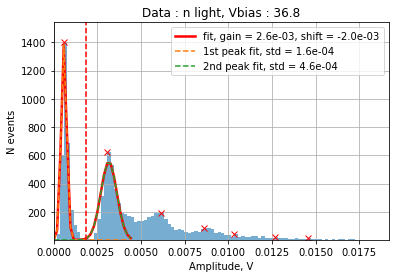

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  36.8
       - data name     :  n dcr
       - Threshold     :  0.0018710429011862318

       - p.e. aproxim. :  0.0023958214802977727
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.0023958214802977727
       - threshold :  0.0018710429011862318
       - threshold element N :  10
       - n_0   9758.0, with err 98.78 
       - n_all 10000.0, with err 100.00 
       - P0    0.98, with err 0.01 
       - DCR Poisson 949520.6046666758


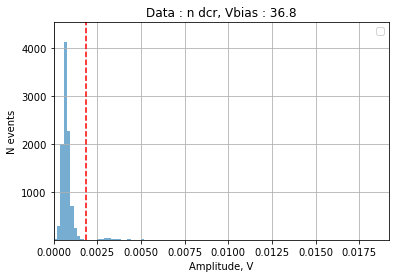

   end: ana_distribution

k LED 1.13, err 0.01 
n pe  1.72, err 0.09 
PDE  66.10, err 3.42 
key :  37.2
   start: ana_distribution
       - Vbias         :  37.2
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.00256975682567256
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.00256975682567256
       - distance_peaks:  8.75
       - found :  8
       - pe_calc :  0.0026725470986994626
       - found :  8
       - p.e. :  0.0026725470986994626
       - left_element :  0.0  right_element :  0.0016446443684304385
       - fit results :  [1.37800000e+03 6.16741638e-04 1.00000000e-05]
       - left_element :  0.0016446443684304385  right_element :  0.004317191467129901
       - fit results :  [6.60000000e+02 1.23348328e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1440.0605324115152
            - gain        :  0.0028225042200503247
            - sigma_0     :  0.0001681402647

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


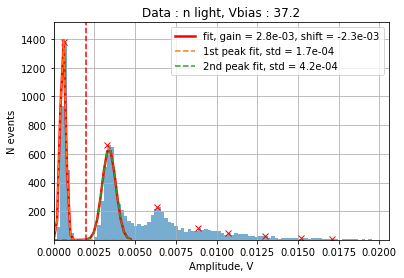

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  37.2
       - data name     :  n dcr
       - Threshold     :  0.001983117651965027

       - p.e. aproxim. :  0.00256975682567256
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.00256975682567256
       - threshold :  0.001983117651965027
       - threshold element N :  10
       - n_0   9734.0, with err 98.66 
       - n_all 10000.0, with err 100.00 
       - P0    0.97, with err 0.01 
       - DCR Poisson 1044968.2784024449


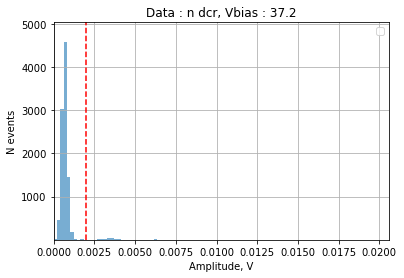

   end: ana_distribution

k LED 1.19, err 0.02 
n pe  1.72, err 0.09 
PDE  69.50, err 3.59 
key :  37.6
   start: ana_distribution
       - Vbias         :  37.6
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0028225042200503247
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.0028225042200503247
       - distance_peaks:  8.75
       - found :  8
       - pe_calc :  0.0031612047264563637
       - found :  8
       - p.e. :  0.0031612047264563637
       - left_element :  0.0  right_element :  0.0015806023632281819
       - fit results :  [1.28900000e+03 4.51600675e-04 1.00000000e-05]
       - left_element :  0.0015806023632281819  right_element :  0.004741807089684545
       - fit results :  [7.2700000e+02 9.0320135e-04 1.0000000e-05]
       - fit parameters : 
            - amplitude_0 :  1562.0489789788562
            - gain        :  0.0030739772303155746
            - sigma_0     :  0.000164242776

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


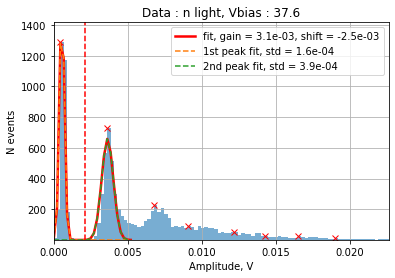

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  37.6
       - data name     :  n dcr
       - Threshold     :  0.0020920254899883884

       - p.e. aproxim. :  0.0028225042200503247
       - Bin size      :  1e-05
       - N bins        :  100
       - pe_aproximate :  0.0028225042200503247
       - threshold :  0.0020920254899883884
       - threshold element N :  10
       - n_0   9706.0, with err 98.52 
       - n_all 9998.0, with err 99.99 
       - P0    0.97, with err 0.01 
       - DCR Poisson 1148869.0700912476


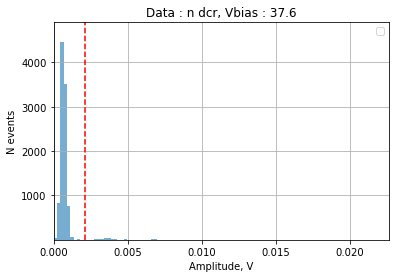

   end: ana_distribution

k LED 1.21, err 0.02 
n pe  1.72, err 0.09 
PDE  70.61, err 3.65 
key :  38.0
   start: ana_distribution
       - Vbias         :  38.0
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0030739772303155746
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.0030739772303155746
       - distance_peaks:  8.75
       - found :  8
       - pe_calc :  0.0031969363195281974
       - found :  8
       - p.e. :  0.0031969363195281974
       - left_element :  0.0  right_element :  0.0019673454274019677
       - fit results :  [1.35500000e+03 7.37754535e-04 1.00000000e-05]
       - left_element :  0.0019673454274019677  right_element :  0.005164281746930165
       - fit results :  [5.83000000e+02 1.47550907e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1423.7543597699514
            - gain        :  0.003169240057256046
            - sigma_0   

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


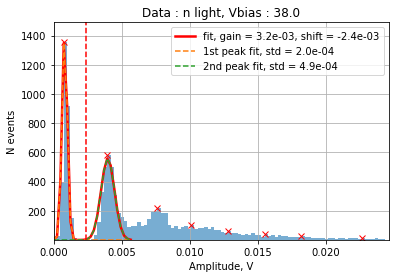

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  38.0
       - data name     :  n dcr
       - Threshold     :  0.0023868859528944513

       - p.e. aproxim. :  0.0030739772303155746
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.0030739772303155746
       - threshold :  0.0023868859528944513
       - threshold element N :  10
       - n_0   9681.0, with err 98.39 
       - n_all 9996.0, with err 99.98 
       - P0    0.97, with err 0.01 
       - DCR Poisson 1241077.954836104


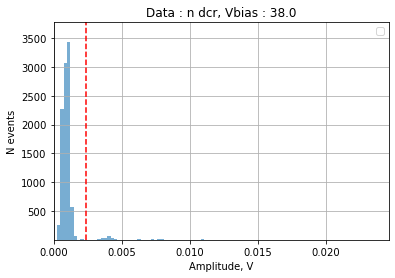

   end: ana_distribution

k LED 1.21, err 0.02 
n pe  1.72, err 0.09 
PDE  70.37, err 3.64 
key :  38.4
   start: ana_distribution
       - Vbias         :  38.4
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.003169240057256046
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003169240057256046
       - distance_peaks:  8.749999999999998
       - found :  8
       - pe_calc :  0.0035495488641267715
       - found :  8
       - p.e. :  0.0035495488641267715
       - left_element :  0.0  right_element :  0.0020283136366438695
       - fit results :  [1.43800000e+03 7.60617614e-04 1.00000000e-05]
       - left_element :  0.0020283136366438695  right_element :  0.005577862500770641
       - fit results :  [5.57000000e+02 1.52123523e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1462.902032814987
            - gain        :  0.003418399807408925
            - 

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


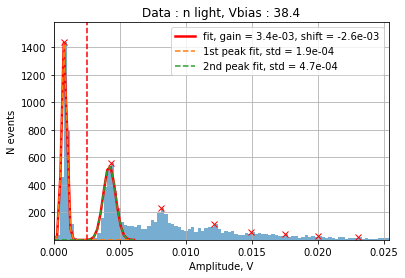

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  38.4
       - data name     :  n dcr
       - Threshold     :  0.0025103760957754353

       - p.e. aproxim. :  0.003169240057256046
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003169240057256046
       - threshold :  0.0025103760957754353
       - threshold element N :  10
       - n_0   9630.0, with err 98.13 
       - n_all 9991.0, with err 99.95 
       - P0    0.96, with err 0.01 
       - DCR Poisson 1426413.253521216


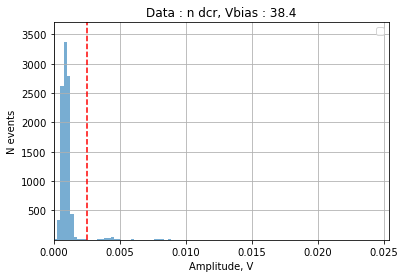

   end: ana_distribution

k LED 1.19, err 0.02 
n pe  1.72, err 0.09 
PDE  69.36, err 3.59 
key :  38.8
   start: ana_distribution
       - Vbias         :  38.8
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.003418399807408925
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003418399807408925
       - distance_peaks:  8.750000000000002
       - found :  8
       - pe_calc :  0.0035551357997052812
       - found :  8
       - p.e. :  0.0035551357997052812
       - left_element :  0.0  right_element :  0.0021877758767417117
       - fit results :  [1.40200000e+03 8.20415954e-04 1.00000000e-05]
       - left_element :  0.0021877758767417117  right_element :  0.005742911676446993
       - fit results :  [5.84000000e+02 1.64083191e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1409.993146572676
            - gain        :  0.003631963009182391
            - 

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


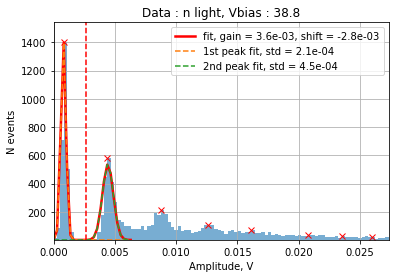

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  38.8
       - data name     :  n dcr
       - Threshold     :  0.002608960926733112

       - p.e. aproxim. :  0.003418399807408925
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003418399807408925
       - threshold :  0.002608960926733112
       - threshold element N :  10
       - n_0   9555.0, with err 97.75 
       - n_all 9980.0, with err 99.90 
       - P0    0.96, with err 0.01 
       - DCR Poisson 1686764.0554703954


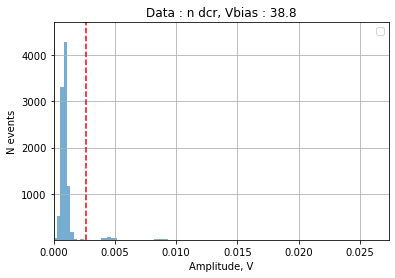

   end: ana_distribution

k LED 1.20, err 0.02 
n pe  1.72, err 0.09 
PDE  69.70, err 3.61 
key :  39.2
   start: ana_distribution
       - Vbias         :  39.2
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.003631963009182391
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003631963009182391
       - distance_peaks:  8.749999999999998
       - found :  7
       - pe_calc :  0.003777241529549687
       - found :  7
       - p.e. :  0.003777241529549687
       - left_element :  0.0  right_element :  0.0023244563258767305
       - fit results :  [1.26800000e+03 8.71671122e-04 1.00000000e-05]
       - left_element :  0.0023244563258767305  right_element :  0.006101697855426418
       - fit results :  [4.81000000e+02 1.74334224e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1377.0699118632604
            - gain        :  0.0039605396804208645
            - 

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


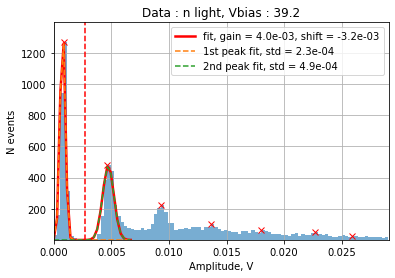

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  39.2
       - data name     :  n dcr
       - Threshold     :  0.0027563344712984903

       - p.e. aproxim. :  0.003631963009182391
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.003631963009182391
       - threshold :  0.0027563344712984903
       - threshold element N :  10
       - n_0   9565.0, with err 97.80 
       - n_all 9949.0, with err 99.74 
       - P0    0.96, with err 0.01 
       - DCR Poisson 1525637.2370157545


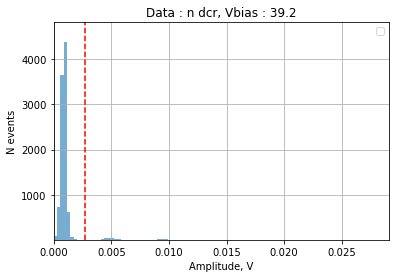

   end: ana_distribution

k LED 1.18, err 0.02 
n pe  1.72, err 0.09 
PDE  68.77, err 3.56 
key :  39.6
   start: ana_distribution
       - Vbias         :  39.6
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.0039605396804208645
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.0039605396804208645
       - distance_peaks:  8.75
       - found :  8
       - pe_calc :  0.004435804442071368
       - found :  8
       - p.e. :  0.004435804442071368
       - left_element :  0.0  right_element :  0.002217902221035684
       - fit results :  [1.20600000e+03 6.33686349e-04 1.00000000e-05]
       - left_element :  0.002217902221035684  right_element :  0.0066537066631070525
       - fit results :  [4.7500000e+02 1.2673727e-03 1.0000000e-05]
       - fit parameters : 
            - amplitude_0 :  1412.939991270003
            - gain        :  0.004283039597359312
            - sigma_0     :  0.

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


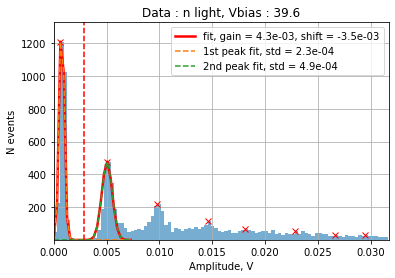

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  39.6
       - data name     :  n dcr
       - Threshold     :  0.0029050194267609634

       - p.e. aproxim. :  0.0039605396804208645
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.0039605396804208645
       - threshold :  0.0029050194267609634
       - threshold element N :  10
       - n_0   9440.0, with err 97.16 
       - n_all 9871.0, with err 99.35 
       - P0    0.96, with err 0.01 
       - DCR Poisson 1730433.5379202175


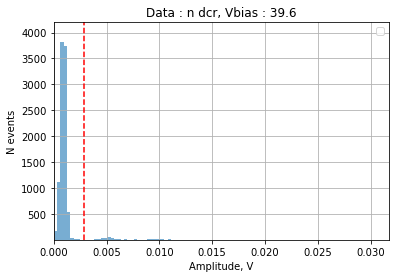

   end: ana_distribution

k LED 1.19, err 0.02 
n pe  1.72, err 0.09 
PDE  69.15, err 3.59 
key :  40.0
   start: ana_distribution
       - Vbias         :  40.0
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.004283039597359312
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004283039597359312
       - distance_peaks:  8.749999999999998
       - found :  8
       - pe_calc :  0.0041117180134649396
       - found :  8
       - p.e. :  0.0041117180134649396
       - left_element :  0.0  right_element :  0.0030837885100987047
       - fit results :  [1.07000000e+03 1.37057267e-03 1.00000000e-05]
       - left_element :  0.0030837885100987047  right_element :  0.007195506523563645
       - fit results :  [3.83000000e+02 2.74114534e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1132.3778610211161
            - gain        :  0.004092753849442499
            -

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


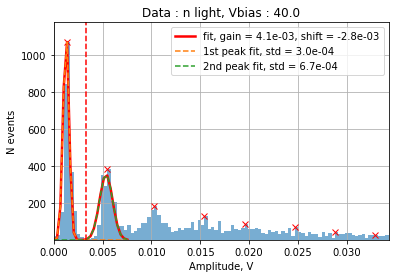

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  40.0
       - data name     :  n dcr
       - Threshold     :  0.003314794393742256

       - p.e. aproxim. :  0.004283039597359312
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004283039597359312
       - threshold :  0.003314794393742256
       - threshold element N :  10
       - n_0   9407.0, with err 96.99 
       - n_all 9884.0, with err 99.42 
       - P0    0.95, with err 0.01 
       - DCR Poisson 1917178.1060677986


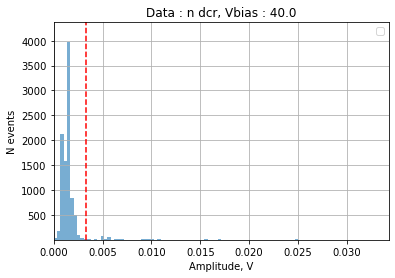

   end: ana_distribution

k LED 1.14, err 0.02 
n pe  1.72, err 0.09 
PDE  66.50, err 3.46 
key :  40.4
   start: ana_distribution
       - Vbias         :  40.4
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.004092753849442499
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004092753849442499
       - distance_peaks:  8.75
       - found :  7
       - pe_calc :  0.004256464003420199
       - found :  7
       - p.e. :  0.004256464003420199
       - left_element :  0.0  right_element :  0.0029467827715985995
       - fit results :  [1.01500000e+03 1.30968123e-03 1.00000000e-05]
       - left_element :  0.0029467827715985995  right_element :  0.007203246775018798
       - fit results :  [3.05000000e+02 2.61936246e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  1036.4113737402788
            - gain        :  0.004385915369147992
            - sigma_0     : 

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


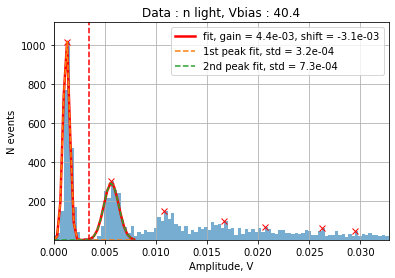

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  40.4
       - data name     :  n dcr
       - Threshold     :  0.0034395593183724643

       - p.e. aproxim. :  0.004092753849442499
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004092753849442499
       - threshold :  0.0034395593183724643
       - threshold element N :  11
       - n_0   9369.0, with err 96.79 
       - n_all 9786.0, with err 98.92 
       - P0    0.96, with err 0.01 
       - DCR Poisson 1687845.9650341317


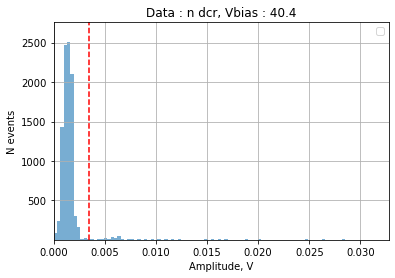

   end: ana_distribution

k LED 1.06, err 0.02 
n pe  1.72, err 0.09 
PDE  61.49, err 3.21 
key :  40.8
   start: ana_distribution
       - Vbias         :  40.8
       - data name     :  n light
       - Threshold     :  nan

       - p.e. aproxim. :  0.004385915369147992
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004385915369147992
       - distance_peaks:  8.75
       - found :  8
       - pe_calc :  0.004561351983913912
       - found :  8
       - p.e. :  0.004561351983913912
       - left_element :  0.0  right_element :  0.0031578590657865544
       - fit results :  [9.95000000e+02 1.40349292e-03 1.00000000e-05]
       - left_element :  0.0031578590657865544  right_element :  0.007719211049700466
       - fit results :  [3.80000000e+02 2.80698584e-03 1.00000000e-05]
       - fit parameters : 
            - amplitude_0 :  996.239492883102
            - gain        :  0.00464976911673765
            - sigma_0     :  0.

/home/andrii/anaconda3/envs/cta-cnn/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


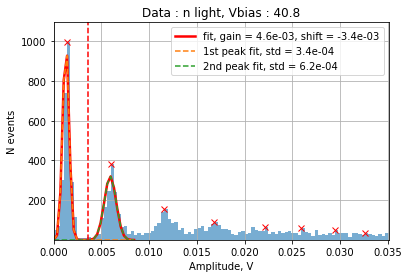

No handles with labels found to put in legend.


   end: ana_distribution

   start: ana_distribution
       - Vbias         :  40.8
       - data name     :  n dcr
       - Threshold     :  0.00359948512887547

       - p.e. aproxim. :  0.004385915369147992
       - Bin size      :  1.0000000000000026e-05
       - N bins        :  100
       - pe_aproximate :  0.004385915369147992
       - threshold :  0.00359948512887547
       - threshold element N :  11
       - n_0   9153.0, with err 95.67 
       - n_all 9628.0, with err 98.12 
       - P0    0.95, with err 0.01 
       - DCR Poisson 1961000.989076868


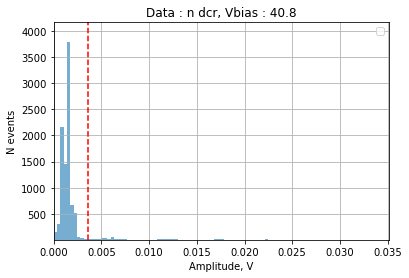

   end: ana_distribution

k LED 1.03, err 0.02 
n pe  1.72, err 0.09 
PDE  60.00, err 3.14 


In [55]:
v_bias = []
pde = []
pde_err = []
pe_amplitude = []

# Fit start parameters:

ap0 = 1000        # first peak amplitude
gain_start = 0.0007 # gain, distance between peaks
sigma0 = 1.e-4    # STD of the first peak
ap1 = 100         # second peak amplitude
sigma1 = 1.e-5    # STD of the second peak
shift = 0.        # shift of the first peak

fit_parameters = {'amplitude_0' : ap0, 
                 'gain' : gain_start,
                 'sigma_0' : sigma0,
                 'amplitude_1' : ap1,
                 'sigma_1': sigma1,
                 'shift': shift}

# Fit parameters range:

ap0_range = (0, 10000)             # first peak amplitude range
gain_range = (1e-4, 0.02)          # gain range
sigma_0_range = (1e-5, 1.e-3)        # range of STD of the first peak
ap1_range = (0, 10000)             # second peak amplitude range
sigsigma_1_rangema1 = (1e-5, 1.5e-3)  # range of STD of the second peak
shift_range = (-0.01, 0.01)        # shift range, of the first peak

fit_parameters_range = {'amplitude_0' : ap0_range, 
                 'gain' : gain_range,
                 'sigma_0' : sigma_0_range,
                 'amplitude_1' : ap1_range,
                 'sigma_1': sigsigma_1_rangema1,
                 'shift': shift_range}


for i_key in pde_405nm_fast.data.keys():
    
    if float(i_key) > 35.:
        print('key : ', i_key)
    
        pde_405nm_fast.calc_pde(i_key, fit_parameters, fit_parameters_range, sipm_area/pd_area, qe_data, file_with_2pd, wavelength, frequncy, doshow = True)
        v_bias.append(float(i_key))
    
        pde_tmp = pde_405nm_fast.data[i_key]['PDE'][0]
        pde_tmp_err = pde_405nm_fast.data[i_key]['PDE err'][0]
    
        pde.append(pde_tmp)
        pde_err.append(pde_tmp_err)
        #pe_amplitude.append(pde_405nm_fast.data[i_key]['p.e. amplitude'][0])
        pe_amplitude.append(pde_405nm_fast.data[i_key]['n light ana']['fit data'][1])
        
        fit_parameters = {'amplitude_0' : pde_405nm_fast.data[i_key]['n light ana']['fit data'][0], 
                          'gain' : pde_405nm_fast.data[i_key]['n light ana']['fit data'][1],
                          'sigma_0' : pde_405nm_fast.data[i_key]['n light ana']['fit data'][2],
                          'amplitude_1' : pde_405nm_fast.data[i_key]['n light ana']['fit data'][3],
                          'sigma_1': pde_405nm_fast.data[i_key]['n light ana']['fit data'][4],
                          'shift': pde_405nm_fast.data[i_key]['n light ana']['fit data'][5]}

### Calculate $V_{BD}$:

V bd :  32.51067620790585


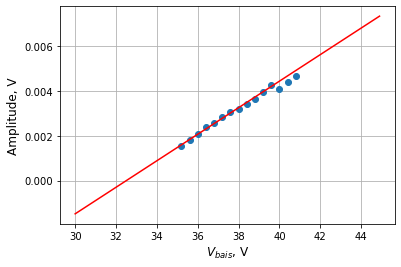

In [58]:
plt.plot(v_bias, pe_amplitude, 'o')
plt.grid()
plt.xlabel("$V_{bais}$, V", fontsize=12)
plt.ylabel("Amplitude, V", fontsize=12)

x = np.arange(30, 45, 0.1)

popt_vbd, pcov_vbd = curve_fit(pde_405nm_fast.line, v_bias[:-3], pe_amplitude[:-3], p0 = [35, 0.1], maxfev=10000)
plt.plot(x, pde_405nm_fast.line(x, *popt_vbd), 'r-', label='fit')

v_bd = -popt_vbd[0]/popt_vbd[1]

print("V bd : ", v_bd)
#plt.xlim(v_bd, 1.05*v_bias[-1])
#plt.ylim(0.0, 1.05*pe_amplitude[-1])

### Plot PDE vs. $\Delta$V:

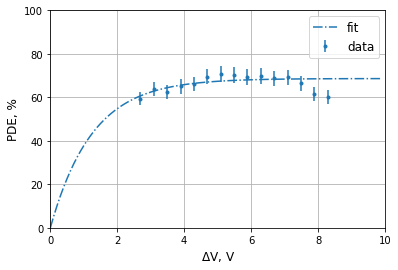

In [59]:
plt.errorbar(np.array(v_bias) - v_bd, pde, yerr = pde_err, fmt = '.', c = 'tab:blue', label = 'data')
plt.grid()
plt.xlim(0, 10)
plt.ylim(0, 100)
plt.xlabel("$\Delta$V, V", fontsize=12)
plt.ylabel("PDE, %", fontsize=12)

x_overvoltage = np.arange(0, 10, 0.1)
popt_405 = pde_405nm_fast.fit_pde_data(np.array(v_bias)[:-1] - v_bd, pde[:-1])
plt.plot(x_overvoltage, pde_405nm_fast.pde_fit(x_overvoltage, *popt_405), linestyle='-.', c = 'tab:blue', label = 'fit')
plt.legend(fontsize=12)